# Model Exploration

In [3]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np

from sklearn import ensemble, linear_model, neighbors, naive_bayes, preprocessing, pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, FeaturesData, Pool

from visualize import print_confusion_matrix 
from modeling import split_data

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_style("whitegrid")
%matplotlib inline

In [4]:
df = pd.read_csv('../data/processed/avito_train_search_stream_data.csv')
unbalanced_df = pd.read_csv('../data/processed/avito_search_stream_data.csv')
print(df.shape)
df.head()

(1116491, 15)


,Unnamed: 0,search_id,is_click,ad_id,position,hist_ctr,category,price,user_id,num_searches,first_search_date,last_search_date,num_days,num_land_page_views,num_phone_req
0,0,121.0,1.0,1220223.0,7.0,0.005422,22.0,1000.0,3817669.0,3,2015-05-01,2015-05-09,8,147.0,0.0
1,1,438.0,1.0,29135166.0,1.0,0.004846,50.0,878.0,2675985.0,8,2015-05-01,2015-05-15,14,2231.0,2.0
2,2,466.0,1.0,6955209.0,7.0,0.007163,42.0,450.0,991573.0,2,2015-05-11,2015-05-18,7,105.0,7.0
3,3,488.0,0.0,20058023.0,1.0,0.008362,40.0,799.0,632068.0,1,2015-05-08,2015-05-08,1,47.0,4.0
4,4,518.0,1.0,24728248.0,1.0,0.004281,7.0,40000.0,1617123.0,1,2015-04-27,2015-04-27,1,49.0,2.0


### Benchmark Scoring and Model Selection
No additional feature engineering post SQL queries

In [5]:
# filter out some colums for MVP model
cols = ['position', 'hist_ctr', 'category', 'price', 'num_searches',
        'num_days', 'num_land_page_views', 'num_phone_req']

target = 'is_click'

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, cols, target) 
print('Training size ', X_train.shape[0])
print('Validation size ', X_val.shape[0])
print('Test size ', X_test.shape[0])

Training size  714553
Validation size  178639
Test size  223299


In [6]:
model_dict = {
    "logistic": linear_model.LogisticRegression(solver="saga", C=20),    
    "random-forest": ensemble.RandomForestClassifier(n_estimators=100),
    "knn": neighbors.KNeighborsClassifier(),
    "nb": naive_bayes.GaussianNB(),
    "xg-boost": XGBClassifier(max_depth=10, gamma= 0.8, eta=0.2, 
                              nthread=6, min_child_weight=4),
    "cat-boost": CatBoostClassifier(max_depth=10, verbose=False, eta=0.2),
}

for model_key in model_dict:  
    
    # create a model, fit, train, predict 
    model = model_dict[model_key]
    if model_key == 'cat-boost':
        cat_features = [0,2]
        model.fit(X_train, y_train, cat_features)
        
    else:
        model.fit(X_train, y_train)
        
    y_pred = model.predict(X_val)
    f1score = f1_score(y_val, y_pred, average='binary')
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    print(f'{model_key} F1 Score =', f1score)
    print(f"{model_key} ROC AUC score =", auc_score)
    

/Users/maileivargas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


logistic F1 Score = 0.5658277117408227
logistic ROC AUC score = 0.5428506610806293
random-forest F1 Score = 0.653372742500729
random-forest ROC AUC score = 0.7202440754886555
knn F1 Score = 0.588154600637882
knn ROC AUC score = 0.6290507752419141
nb F1 Score = 0.6585748850326074
nb ROC AUC score = 0.5860326093467949
xg-boost F1 Score = 0.6713712639132153
xg-boost ROC AUC score = 0.7389025698611109
cat-boost F1 Score = 0.6672154439457837
cat-boost ROC AUC score = 0.7312150867967241


The best perfoming models above are:
* Random Forest
* XGBClassifier
* CATBoost

Next step is to make some changes in the data and see if scores of above 3 models improve

### Additional Feature Engineering

In [7]:
# Import new csv that included additional features from SQL queries
# so addidional feature engineering can be done
df2 = pd.read_csv('../data/processed/avito_train_search_stream_data2.csv')

# new feature
# get the price ratio per category
mean_dict = dict(df2.groupby('category')['price'].mean())
def get_ratio(row):
    return row['price'] / mean_dict[row['category']]

df2['price_ratio'] = df2.apply(get_ratio, axis=1)

# new feature
# length of title
df2['title_length'] = df2['title'].apply(lambda title: len(title))
df2.head()

# new interaction features (these were added one by one to verify effect)
# started with 12 interaction features and narrowed them down to below

# interaction between price and num searches
df2['price_search'] = df2['price'] * df2['num_searches']

# interaction between position and hist
df2['pos_hist'] = df2['position'] * df2['hist_ctr']

print(df2.shape)
df2.head()

(1092423, 23)


,Unnamed: 0,search_id,is_click,ad_id,position,hist_ctr,category,day_of_week,hour_of_day,price,...,num_searches,first_search_date,last_search_date,num_days,num_land_page_views,num_phone_req,price_ratio,title_length,price_search,pos_hist
0,0,121.0,1.0,1220223.0,7.0,0.005422,22.0,6.0,22.0,1000.0,...,3,2015-05-01 06:33:18,2015-05-09 22:21:40,9,147.0,0.0,0.058064,50,3000.0,0.037954
1,1,438.0,1.0,29135166.0,1.0,0.004846,50.0,5.0,15.0,878.0,...,8,2015-05-01 15:48:08,2015-05-15 17:36:01,15,2231.0,2.0,0.575951,23,7024.0,0.004846
2,2,466.0,1.0,6955209.0,7.0,0.007163,42.0,1.0,21.0,450.0,...,2,2015-05-11 21:41:25,2015-05-18 22:21:49,8,105.0,7.0,0.046668,46,900.0,0.050141
3,3,488.0,0.0,20058023.0,1.0,0.008362,40.0,5.0,22.0,799.0,...,1,2015-05-08 22:38:09,2015-05-08 22:38:09,2,47.0,4.0,0.636833,48,799.0,0.008362
4,4,518.0,1.0,24728248.0,1.0,0.004281,7.0,1.0,11.0,40000.0,...,1,2015-04-27 11:33:25,2015-04-27 11:33:25,2,49.0,2.0,2.722949,20,40000.0,0.004281


In [14]:
# df2.to_csv('../data/processed/avito_train_search_stream_data3.csv')

**CATBoost** 
* handles One-Hot-Encoding internally, thus data doesn't need to be changed.

In [8]:
# select the columns of interest
cols = ['category', 'day_of_week', 'hour_of_day', 'region', 
        'position', 'hist_ctr', 'price', 'num_searches', 
        'num_days', 'num_land_page_views', 'num_phone_req', 
        'price_ratio', 'title_length', 'price_search', 
        'pos_hist']

target = 'is_click'

X_train_cat, y_train_cat, X_val_cat, y_val_cat, X_test_cat, y_test_cat = split_data(df2, cols, target) 
    
cat_boost = CatBoostClassifier(max_depth=10, verbose=False, eta=0.2)
# informing model which columns are categorical
cat_features = [0,1,2,3]
cat_boost.fit(X_train_cat, y_train_cat, cat_features)

y_pred_cat = cat_boost.predict(X_val_cat)
f1score_cat = f1_score(y_val_cat, y_pred_cat, average='binary')
auc_score_cat = roc_auc_score(y_val_cat, cat_boost.predict_proba(X_val_cat)[:,1])
print('CATBoost F1 Score =', f1score_cat)
print("CATBoost ROC AUC score =", auc_score_cat)

CATBoost F1 Score = 0.6714622533534771
CATBoost ROC AUC score = 0.7353793701389637


**One-Hot-Encode**  for Random Forest and XGBoost models

In [9]:
# One-Hot-Encode for Random Forest and XGBoost
df2['category'] = df2['category'].apply(lambda x: str(int(x)))
df2['day_of_week'] = df2['day_of_week'].apply(lambda x: str(int(x)))
df2['hour_of_day'] = df2['hour_of_day'].apply(lambda x: str(int(x)))
df2['region'] = df2['region'].apply(lambda x: str(int(x)))

cols = ['is_click', 'position', 'hist_ctr', 'price', 
        'num_searches', 'num_days', 'num_land_page_views', 
        'num_phone_req', 'price_ratio', 'title_length', 
        'price_search', 'pos_hist']

one_hot = pd.get_dummies(df2[['category', 'day_of_week', 'hour_of_day', 'region']], drop_first=True)
one_hot_df = df2[cols].join(one_hot)
one_hot_df.head()

,is_click,position,hist_ctr,price,num_searches,num_days,num_land_page_views,num_phone_req,price_ratio,title_length,...,region_77,region_78,region_79,region_8,region_80,region_81,region_82,region_83,region_84,region_9
0,1.0,7.0,0.005422,1000.0,3,9,147.0,0.0,0.058064,50,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,0.004846,878.0,8,15,2231.0,2.0,0.575951,23,...,0,0,0,0,0,0,0,0,0,0
2,1.0,7.0,0.007163,450.0,2,8,105.0,7.0,0.046668,46,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.008362,799.0,1,2,47.0,4.0,0.636833,48,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,0.004281,40000.0,1,2,49.0,2.0,2.722949,20,...,0,0,0,0,0,0,0,0,0,0


**Random Forest** and **XGBoost**

In [10]:
# split One-Hot-Encode dataset for Random Forest and XGBoost
cols = list(one_hot_df.columns)[1:]
target = 'is_click'
X_train, y_train, X_val, y_val, X_test, y_test = split_data(one_hot_df, cols, target) 

# retrain data on new dataset that includes additional features
# some parameter tuning 
model_dict = {
    "random-forest": ensemble.RandomForestClassifier(n_estimators=100),
    "xg-boost": XGBClassifier(max_depth=10, gamma= 0.8, eta=0.2, 
                              nthread=6, min_child_weight=4),
}

for model_key in model_dict:  
    
    # create a model, fit, train, predict 
    model = model_dict[model_key]
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_val)
    f1score = f1_score(y_val, y_pred, average='binary')
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    print(f'{model_key} F1 Score =', round(f1score, 5))
    print(f"{model_key} ROC AUC score =", round(auc_score, 5))

random-forest F1 Score = 0.66999
random-forest ROC AUC score = 0.73777
xg-boost F1 Score = 0.67702
xg-boost ROC AUC score = 0.74135


## Random Search CV -> Grid Search CV -> On Subset due to time constraints

**Random Forest CV**

In [11]:
# main code found from: 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 10, 20, 50, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'bootstrap': bootstrap,
                 'max_depth': max_depth,
                 'max_features': max_features,
                 'min_samples_leaf': min_samples_split,
                 'min_samples_split': min_samples_leaf, 
                 'n_estimators': n_estimators
                }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ensemble.RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
# smaller sample of the training set to speed up process
rf_random.fit(X_train[:10000], y_train[:10000]) 

# get result of random cv
rf_best_params = rf_random.best_params_
rf_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.6s
/Users/maileivargas/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 100}

In [12]:
# Create the parameter grid based on the results of random search 
rf_param_grid = {'bootstrap': [False],
                'max_depth': [15, 20],
                'max_features': ['sqrt'],
                'min_samples_leaf': [2, 3],
                'min_samples_split': [4, 6],
                'n_estimators': [500]
            }  # 16 combinations

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, 
                               param_grid = rf_param_grid, 
                               cv = 3, 
                               n_jobs = -1, 
                               verbose = 2)

# Fit the grid search to the data
rf_grid_search.fit(X_train[:50000], y_train[:50000])
print('Best parameters:')
print(rf_grid_search.best_params_)

best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_val[:50000])
f1score_rf = f1_score(y_val[:50000], y_pred_rf, average='binary')
auc_score_rf = roc_auc_score(y_val[:50000], best_rf.predict_proba(X_val[:50000])[:,1])
print('Random Forest w/Grid Search F1 Score =', round(f1score_rf, 5))
print("Random Forest w/Grid Search ROC AUC score =", round(auc_score_rf, 5))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  5.1min remaining:   27.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.1min finished


Best parameters:
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}
Random Forest w/Grid Search F1 Score = 0.6711
Random Forest w/Grid Search ROC AUC score = 0.72695


**XGBoost CV**

In [13]:
# main code found from: 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Maximum number of levels in tree
max_depth = [2, 10, 20, 50]
# Subsample ratio of columns when constructing each tree
colsample_bytree = [0.2, 0.5, 1]
# Subsample ratio of columns for each split, in each level
colsample_bylevel = [0.2, 0.5, 1]
# Minimum loss reduction required to make a further partition on a leaf node of the tree
gamma = [0.2, 0.4]
# Boosting learning rate (xgb's "eta")
learning_rate = [0.2, 0.4]
# Number of parallel threads used to run xgboost
n_jobs = [4, 6, 10]
# Minimum sum of instance weight(hessian) needed in a child
min_child_weight = [4, 6, 10]

xg_random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'colsample_bytree': colsample_bytree,
                    'colsample_bylevel': colsample_bylevel,
                    'gamma': gamma, 
                    'learning_rate': learning_rate,
                    'n_jobs': n_jobs,
                    'min_child_weight': min_child_weight
                }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, 
                               param_distributions = xg_random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
xg_random.fit(X_train[:5000], y_train[:5000])

# get result of random cv
xg_best_params = xg_random.best_params_
xg_best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.4min finished


{'colsample_bylevel': 0.2,
 'colsample_bytree': 1,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 4,
 'n_estimators': 100,
 'n_jobs': 4}

In [14]:
# Create the parameter grid based on the results of random search 
xg_param_grid = {'colsample_bylevel': [0.1, 0.2],
                 'colsample_bytree': [1],
                 'gamma': [0.1, 0.2],
                 'learning_rate': [0.1, 0.2],
                 'max_depth': [2, 3],
                 'min_child_weight': [4],
                 'n_estimators': [100],
                 'n_jobs': [2, 4]
            }  # 32 combinations

# Instantiate the grid search model
xg_grid_search = GridSearchCV(estimator = xg, 
                               param_grid = xg_param_grid, 
                               cv = 3, 
                               n_jobs = -1, 
                               verbose = 2)

# Fit the grid search to the data
xg_grid_search.fit(X_train[:50000], y_train[:50000])
print('Best parameters:')
print(xg_grid_search.best_params_)

best_xg = xg_grid_search.best_estimator_
y_pred_xg = best_xg.predict(X_val[:50000])
f1score_xg = f1_score(y_val[:50000], y_pred_xg, average='binary')
auc_score_xg = roc_auc_score(y_val[:50000], best_xg.predict_proba(X_val[:50000])[:,1])
print('XGBoost w/Grid Search F1 Score =', round(f1score_xg, 5))
print("XGBoost w/Grid Search ROC AUC score =", round(auc_score_xg, 5))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.4min finished


Best parameters:
{'colsample_bylevel': 0.2, 'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'n_jobs': 2}
XGBoost w/Grid Search F1 Score = 0.67158
XGBoost w/Grid Search ROC AUC score = 0.72555


### Final Training 
with the GridSearch Parameters

In [15]:
unbalanced_y_test = (y_test[y_test == 1].sample(2000)
                     .append(y_test[y_test == 0].sample(100000))
                     .sort_index())
unbalanced_X_test = (X_test[X_test.index.isin(unbalanced_y_test.index)]
                     .sort_index())

unbalanced_y_test.value_counts()

0.0    100000
1.0      2000
Name: is_click, dtype: int64

**Random Forest Test**

In [17]:
# train data with hyperparameters for Random Forest
final_rf_model = ensemble.RandomForestClassifier(**rf_grid_search.best_params_)

# create a model, fit, train, predict 
final_rf_model.fit(X_train, y_train)  

# on balanced test data
rf_pred_final = final_rf_model.predict(X_test)
rf_final_f1score = f1_score(y_test, rf_pred_final, average='binary')
rf_final_auc_score = roc_auc_score(y_test, final_rf_model.predict_proba(X_test)[:,1])
print('Random Forest Test balanced F1 Score =', round(rf_final_f1score, 5))
print('Random Forest Test balanced ROC AUC score =', round(rf_final_auc_score, 5))

# on unbalanced test data
rf_pred_final_un = final_rf_model.predict(unbalanced_X_test)
rf_final_f1score_un = f1_score(unbalanced_y_test, rf_pred_final_un, average='binary')
rf_final_auc_score_un = roc_auc_score(unbalanced_y_test, 
                                      final_rf_model.predict_proba(unbalanced_X_test)[:,1])
print('Random Forest Test UNbalanced F1 Score =', round(rf_final_f1score_un, 5))
print('Random Forest Test UNbalanced ROC AUC score =', round(rf_final_auc_score_un, 5))

Random Forest Test balanced F1 Score = 0.67174
Random Forest Test balanced ROC AUC score = 0.73357
Random Forest Test UNbalanced F1 Score = 0.07185
Random Forest Test UNbalanced ROC AUC score = 0.72794


**XGBoost Test**

In [18]:
# train data with hyperparameters for XGBoost
final_xg_model = XGBClassifier(**xg_grid_search.best_params_)

# create a model, fit, train, predict 
final_xg_model.fit(X_train, y_train)  

# on balanced test data
xg_pred_final = final_xg_model.predict(X_test)
xg_final_f1score = f1_score(y_test, xg_pred_final, average='binary')
xg_final_auc_score = roc_auc_score(y_test, final_xg_model.predict_proba(X_test)[:,1])
print('XGBoost Test balanced F1 Score =', round(xg_final_f1score, 5))
print('XGBoost Test balanced ROC AUC score =', round(xg_final_auc_score, 5))
# XGBoost Test F1 Score = 0.66721
# XGBoost Test ROC AUC score = 0.72324

# on unbalanced test data
xg_pred_final_un = final_xg_model.predict(unbalanced_X_test)
xg_final_f1score_un = f1_score(unbalanced_y_test, xg_pred_final_un, average='binary')
xg_final_auc_score_un = roc_auc_score(unbalanced_y_test, 
                                      final_xg_model.predict_proba(unbalanced_X_test)[:,1])
print('XGBoost Test UNbalanced F1 Score =', round(xg_final_f1score_un, 5))
print('XGBoost Test UNbalanced ROC AUC score =', round(xg_final_auc_score_un, 5))

XGBoost Test balanced F1 Score = 0.66721
XGBoost Test balanced ROC AUC score = 0.72324
XGBoost Test UNbalanced F1 Score = 0.06984
XGBoost Test UNbalanced ROC AUC score = 0.71861


**CATBoost Test**

In [19]:
unbalanced_y_test_cat = (y_test_cat[y_test_cat == 1].sample(2000)
                         .append(y_test_cat[y_test_cat == 0].sample(100000))
                         .sort_index())
unbalanced_X_test_cat = (X_test_cat[X_test_cat.index.isin(unbalanced_y_test_cat.index)]
                         .sort_index())
unbalanced_y_test_cat.value_counts()

0.0    100000
1.0      2000
Name: is_click, dtype: int64

In [20]:
cat_boost = CatBoostClassifier(max_depth=10, 
                               verbose=False, 
                               eta=0.2, 
                               n_estimators=500, 
                               colsample_bylevel=0.2)

# informing model which columns are categorical
cat_features = [0,1,2,3]
cat_boost.fit(X_train_cat, y_train_cat, cat_features)

# on balanced test data
y_pred_cat = cat_boost.predict(X_test_cat)
f1score_cat = f1_score(y_test_cat, y_pred_cat, average='binary')
auc_score_cat = roc_auc_score(y_test_cat, cat_boost.predict_proba(X_test_cat)[:,1])
print('CATBoost balanced F1 Score =', f1score_cat)
print("CATBoost balanced ROC AUC score =", auc_score_cat)

# on UNbalanced test data
y_pred_cat_un = cat_boost.predict(unbalanced_X_test_cat)
f1score_cat_un= f1_score(unbalanced_y_test_cat, y_pred_cat_un, average='binary')
auc_score_cat_un = roc_auc_score(unbalanced_y_test_cat, 
                                  cat_boost.predict_proba(unbalanced_X_test_cat)[:,1])
print('CATBoost UNbalanced F1 Score =', f1score_cat_un)
print("CATBoost UNbalanced ROC AUC score =", auc_score_cat_un)

CATBoost balanced F1 Score = 0.6736122222273015
CATBoost balanced ROC AUC score = 0.7377021300430245
CATBoost UNbalanced F1 Score = 0.07261782092304354
CATBoost UNbalanced ROC AUC score = 0.7314907625


## Visualize Results

### ROC Curves

In [ ]:
# create a ROC AUC graph for best performing model 
rf_probs = final_rf_model.predict_proba(X_test)[:,1]
xg_probs = final_xg_model.predict_proba(X_test)[:,1]
cat_probs = cat_boost.predict_proba(X_test_cat)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)         # Random Forest
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs)         # XGBoost
cat_fpr, cat_tpr, _ = roc_curve(y_test_cat, cat_probs)  # CATBoost

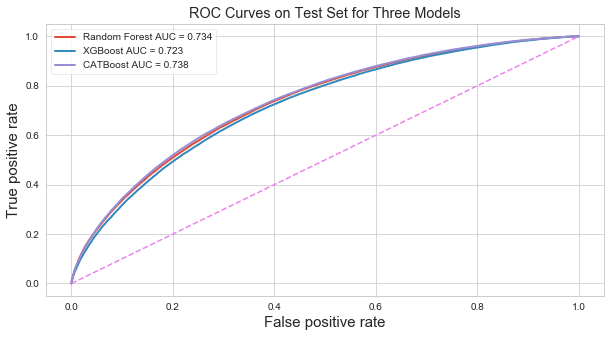

In [90]:
plt.figure(figsize=(10,5))
# plt.subplot(1, 2, 2)
plt.plot(rf_fpr, rf_tpr, lw=2)
plt.plot(xg_fpr, xg_tpr, lw=2)
plt.plot(cat_fpr, cat_tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate', size=15)
plt.ylabel('True positive rate', size=15)
plt.title('ROC Curves on Test Set for Three Models')
plt.legend([f'Random Forest AUC = {round(rf_final_auc_score,3)}', 
            f'XGBoost AUC = {round(xg_final_auc_score,3)}', 
            f'CATBoost AUC = {round(auc_score_cat,3)}']);
# print("Random Forest ROC AUC score =", rf_final_auc_score)

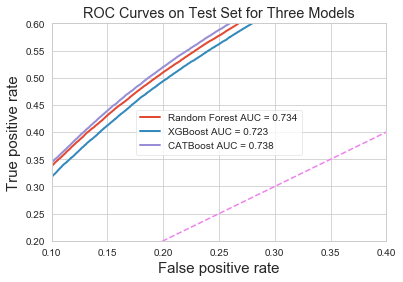

In [91]:
plt.plot(rf_fpr, rf_tpr, lw=2)
plt.plot(xg_fpr, xg_tpr, lw=2)
plt.plot(cat_fpr, cat_tpr, lw=2)
plt.plot([0,1],[0,1], c='violet', ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate', size=15)
plt.ylabel('True positive rate', size=15)
plt.title('ROC Curves on Test Set for Three Models')
plt.legend([f'Random Forest AUC = {round(rf_final_auc_score,3)}', 
            f'XGBoost AUC = {round(xg_final_auc_score,3)}', 
            f'CATBoost AUC = {round(auc_score_cat,3)}']);
plt.axis([0.1, 0.4, 0.2, 0.6]);

### Confusion Matrix for best performing model 
* (balanced and unbalanced)

CAT-Boost Confusion Matrix (balanced test). F1 Score = 0.6736122222273015
CAT-Boost Confusion Matrix (unbalanced test). F1 Score = 0.07621678719427967


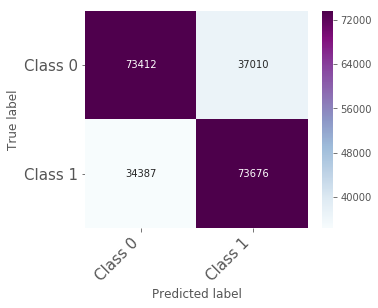

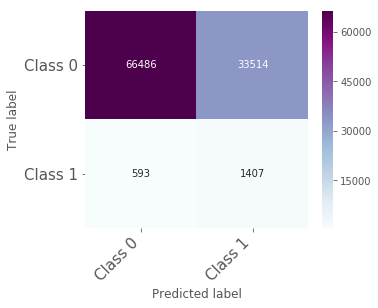

In [74]:
# create a confusion matrix for best performing model (Balanced)
print(f'CAT-Boost Confusion Matrix (balanced test). F1 Score = {f1score_cat}')
cat_conf_mat = confusion_matrix(y_true=y_test_cat, y_pred=y_pred_cat)
cm = print_confusion_matrix(cat_conf_mat, ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15);

print(f'CAT-Boost Confusion Matrix (unbalanced test). F1 Score = {f1score_cat_un}')
# create a confusion matrix for best performing model (unbalanced)
cat_un_conf_mat = confusion_matrix(y_true=unbalanced_y_test_cat, y_pred=y_pred_cat_un)
cm = print_confusion_matrix(cat_un_conf_mat, ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15);

### Learning Curves

In [26]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(8,5))
    plt.title(title, size=20)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", size=15)
    plt.ylabel("F1 Score", size=15)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, scoring='f1', 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="dodgerblue", label='Train Std Dev')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, 
                     color="darkviolet", label='Validation Std Dev')
    plt.plot(train_sizes, train_scores_mean, 'o-', color="dodgerblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="darkviolet",
             label="Cross-validation score")
    plt.plot(100000, xg_final_f1score, marker='*', markersize=15, 
             color='k', label='Model Score')

    plt.legend(loc="best")
    return plt

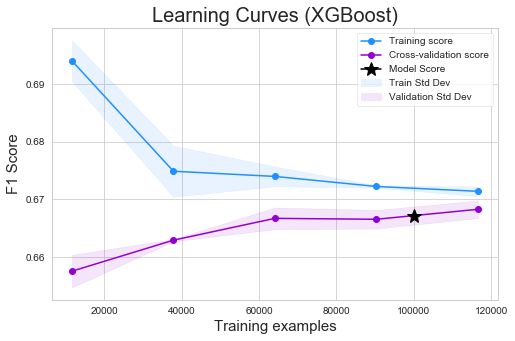

In [27]:
title = 'Learning Curves (XGBoost)'
# final_xg_model.fit(X_train, y_train)  
plot_learning_curve(final_xg_model, title, X_val, y_val, ylim=None, cv=3,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5));

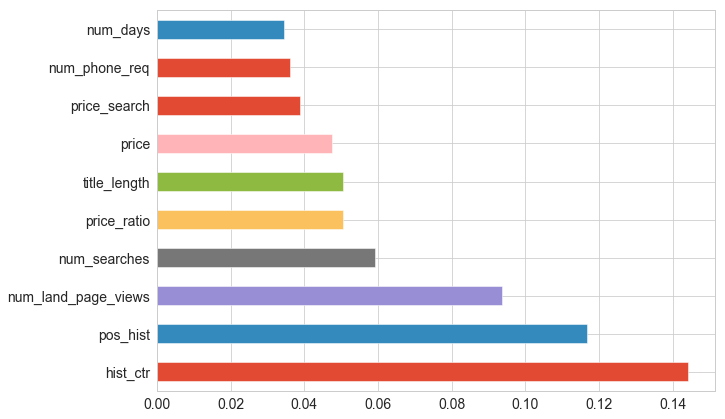

In [55]:
# final_xg_model.feature_importances_

feat_importances = pd.Series(final_xg_model.feature_importances_, 
                             index=X_val.columns)
plt.figure(figsize=(10,7))
feat_importances.nlargest(10).plot(kind='barh')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [39]:
X_train_cat.columns

Index(['category', 'day_of_week', 'hour_of_day', 'region', 'position',
       'hist_ctr', 'price', 'num_searches', 'num_days', 'num_land_page_views',
       'num_phone_req', 'price_ratio', 'title_length', 'price_search',
       'pos_hist'],
      dtype='object')

In [53]:
X_test_cat['position'].value_counts()

1.0    134795
7.0     83690
Name: position, dtype: int64